In [1]:
import keras
from keras.datasets import cifar10
import matplotlib.pyplot as plt
import numpy as np
class CIFAR10Data(object):
    def __init__(self):
        (self.x_train, self.y_train), (self.x_test, self.y_test) = cifar10.load_data()
        self.classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
        print('CIFAR10 Training data shape:', self.x_train.shape)
        print('CIFAR10 Training label shape', self.y_train.shape)
        print('CIFAR10 Test data shape', self.x_test.shape)
        print('CIFAR10 Test label shape', self.y_test.shape)

    def get_stretch_data(self, subtract_mean=True):
        """
        reshape X each image to row vector, and transform Y to one_hot label.
        :param subtract_mean:Indicate whether subtract mean image.
        :return: x_train, one_hot_y_train, x_test, one_hot_y_test
        """
        num_classes = len(self.classes)
        # x_train = np.reshape(self.x_train, (self.x_train.shape[0], -1)).astype('float64')
        x_train = np.reshape(self.x_train, (self.x_train.shape[0], -1)).astype('float16')
        y_train = keras.utils.to_categorical(self.y_train, num_classes)

        # x_test = np.reshape(self.x_test, (self.x_test.shape[0], -1)).astype('float64')
        x_test = np.reshape(self.x_test, (self.x_test.shape[0], -1)).astype('float16')
        y_test = keras.utils.to_categorical(self.y_test, num_classes)

        if subtract_mean:
            mean_image = np.mean(x_train, axis=0).astype('uint8')
            x_train -= mean_image
            x_test -= mean_image
            # print(x_mean[:10])
            # plt.figure(figsize=(4, 4))
            # plt.imshow(x_mean.reshape((32, 32, 3)))
            # plt.show()

        return x_train, y_train, x_test, y_test

    def get_data(self, subtract_mean=True, output_shape=None):
        """
        The data is not reshaped, keep 3 channel.
        :param subtract_mean:Indicate whether subtract mean image.
        :param output_shape:Indicate whether resize image
        :return: x_train, one_hot_y_train, x_test, one_hot_y_test
        """
        num_classes = len(self.classes)
        x_train = self.x_train
        x_test = self.x_test
        # if output_shape:resize
        #     x_train = np.array([cv2.resize(img, output_shape) for img in self.x_train])
        #     x_test = np.array([cv2.(img, output_shape) for img in self.x_test])

        x_train = x_train.astype('float16')
        y_train = keras.utils.to_categorical(self.y_train, num_classes)

        x_test = x_test.astype('float16')
        y_test = keras.utils.to_categorical(self.y_test, num_classes)

        if subtract_mean:
            mean_image = np.mean(x_train, axis=0)
            x_train -= mean_image
            x_test -= mean_image
        return x_train, y_train, x_test, y_test


def plot_cifar10(cifar_data, num_sample_per_class):
    """
    random select num_sample_per_class to plot
    """
    num_classes = len(cifar_data.classes)

    plt.figure()
    for y, cls in enumerate(cifar_data.classes):
        cls_indices = np.flatnonzero(cifar_data.y_train == y)
        samples_indices = np.random.choice(cls_indices, num_sample_per_class, replace=False)
        samples = cifar_data.x_train[samples_indices]
        for x, sample in enumerate(samples):
            # subplot index count from 1
            plt_idx = x * num_classes + y + 1
            plt.subplot(num_sample_per_class, num_classes, plt_idx)
            plt.imshow(sample)
            plt.axis('off')
            if x == 0:
                plt.title(cls)
    plt.show()

Using TensorFlow backend.


In [2]:
import matplotlib.pyplot as plt
import os
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

import tensorflow as tf 
from keras import backend as k
import os


%load_ext autoreload
%autoreload 2

In [7]:


# get data
cifar10_data = CIFAR10Data()
x_train, y_train, x_test, y_test = cifar10_data.get_data(subtract_mean=True)

num_train = int(x_train.shape[0] * 0.8)
num_val = x_train.shape[0] - num_train
mask = list(range(num_train, num_train+num_val))
x_val = x_train[mask]
y_val = y_train[mask]

mask = list(range(num_train))
x_train = x_train[mask]
y_train = y_train[mask]
print(x_train.shape)



CIFAR10 Training data shape: (50000, 32, 32, 3)
CIFAR10 Training label shape (50000, 1)
CIFAR10 Test data shape (10000, 32, 32, 3)
CIFAR10 Test label shape (10000, 1)
(40000, 32, 32, 3)


In [8]:
from keras.models import Model
from keras.models import Input
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Conv2D
from keras.layers import MaxPool2D
from keras.layers import BatchNormalization
from keras.layers import Activation
from keras import regularizers


def conv2d_bn_relu(model,
                   filters,
                   block_index, layer_index,
                   weight_decay=.0, padding='same'):
    conv_name = 'conv' + str(block_index) + '-' + str(layer_index)
    model = Conv2D(filters=filters,
                   kernel_size=(3, 3),
                   padding=padding,
                   kernel_regularizer=regularizers.l2(weight_decay),
                   strides=(1, 1),
                   name=conv_name,
                   )(model)
    bn_name = 'bn' + str(block_index) + '-' + str(layer_index)
    model = BatchNormalization(name=bn_name)(model)
    relu_name = 'relu' + str(block_index) + '-' + str(layer_index)
    model = Activation('relu', name=relu_name)(model)
    return model


def dense2d_bn_dropout(model, units, weight_decay, name):
    model = Dense(units,
                  kernel_regularizer=regularizers.l2(weight_decay),
                  name=name,
                  )(model)
    model = BatchNormalization(name=name + '-bn')(model)
    model = Activation('relu', name=name + '-relu')(model)
    model = Dropout(0.5, name=name + '-dropout')(model)
    return model


def VGGNet(classes, input_shape, weight_decay,
           conv_block_num=5,
           fc_layers=2, fc_units=4096):
    input = Input(shape=input_shape)
    # block 1
    x = conv2d_bn_relu(model=input,
                       filters=64,
                       block_index=1, layer_index=1,
                       weight_decay=weight_decay
                       )
    x = conv2d_bn_relu(model=x,
                       filters=64,
                       block_index=1, layer_index=2,
                       weight_decay=weight_decay)
    x = MaxPool2D(name='pool1')(x)

    # block 2
    if conv_block_num >= 2:
        x = conv2d_bn_relu(x,
                           filters=128,
                           block_index=2, layer_index=1,
                           weight_decay=weight_decay)
        x = conv2d_bn_relu(x,
                           filters=128,
                           block_index=2, layer_index=2,
                           weight_decay=weight_decay)
        x = MaxPool2D(name='pool2')(x)

    # block 3
    if conv_block_num >= 3:
        x = conv2d_bn_relu(x,
                           filters=256,
                           block_index=3, layer_index=1,
                           weight_decay=weight_decay)
        x = conv2d_bn_relu(x,
                           filters=256,
                           block_index=3, layer_index=2,
                           weight_decay=weight_decay)
        x = conv2d_bn_relu(x,
                           filters=256,
                           block_index=3, layer_index=3,
                           weight_decay=weight_decay)
        x = MaxPool2D(name='pool3')(x)

    # block 4
    if conv_block_num >= 4:
        x = conv2d_bn_relu(x,
                           filters=512,
                           block_index=4, layer_index=1,
                           weight_decay=weight_decay)
        x = conv2d_bn_relu(x,
                           filters=512,
                           block_index=4, layer_index=2,
                           weight_decay=weight_decay)
        x = conv2d_bn_relu(x,
                           filters=512,
                           block_index=4, layer_index=3,
                           weight_decay=weight_decay)
        x = MaxPool2D(name='pool4')(x)

    # block 5
    if conv_block_num >= 5:
        x = conv2d_bn_relu(x,
                           filters=512,
                           block_index=5, layer_index=1,
                           weight_decay=weight_decay)
        x = conv2d_bn_relu(x,
                           filters=512,
                           block_index=5, layer_index=2,
                           weight_decay=weight_decay)
        x = conv2d_bn_relu(x,
                           filters=512,
                           block_index=5, layer_index=3,
                           weight_decay=weight_decay)
        x = MaxPool2D(name='pool5')(x)

    x = Flatten(name='flatten')(x)
    if fc_layers >= 1:
        x = dense2d_bn_dropout(x, fc_units, weight_decay, 'fc6')
        if fc_layers >= 2:
            x = dense2d_bn_dropout(x, fc_units, weight_decay, 'fc7')
    out = Dense(classes, activation='softmax', name='predictions')(x)
    model = Model(input, out)
    return model

In [9]:


weight_decay = 5e-4
lr = 1e-1
num_classes = 10

vgg = VGGNet(classes=num_classes, 
             input_shape=x_train.shape[1:], 
             weight_decay=weight_decay, 
             conv_block_num=4,
             fc_layers=2,
             fc_units=512
             ) 

# sgd
opt = keras.optimizers.SGD(lr=lr, momentum=0.9, nesterov=False)
vgg.compile(loss='categorical_crossentropy', 
            optimizer=opt, 
            metrics=['accuracy'])
vgg.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv1-1 (Conv2D)             (None, 32, 32, 64)        1792      
_________________________________________________________________
bn1-1 (BatchNormalization)   (None, 32, 32, 64)        256       
_________________________________________________________________
relu1-1 (Activation)         (None, 32, 32, 64)        0         
_________________________________________________________________
conv1-2 (Conv2D)             (None, 32, 32, 64)        36928     
_________________________________________________________________
bn1-2 (BatchNormalization)   (None, 32, 32, 64)        256       
_________________________________________________________________
relu1-2 (Activation)         (None, 32, 32, 64)        0   

In [10]:


%%time
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import LearningRateScheduler
# fit data with data augmentation or not
data_augmentation = True


def lr_scheduler(epoch):
    return lr * (0.1 ** (epoch // 50))

reduce_lr = LearningRateScheduler(lr_scheduler)
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
#                               patience=10, min_lr=1e-6, verbose=1)

batch_size = 128
epochs = 120

if data_augmentation:
    # datagen
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=15,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False, # randomly flip images
    ) 
    # (std, mean, and principal components if ZCA whitening is applied).
    # datagen.fit(x_train)
    print('train with data augmentation')
    history = vgg.fit_generator(generator=datagen.flow(x_train, y_train, batch_size=batch_size),
                                epochs=epochs,
                                callbacks=[reduce_lr],
                                validation_data=(x_val, y_val)
                                )
else:
    print('train without data augmentation')
    history = vgg.fit(x_train, y_train, 
                      batch_size=batch_size, epochs=epochs, 
                      callbacks=[reduce_lr],
                      validation_data=(x_val, y_val)
                      )



train with data augmentation
Epoch 1/120
313/313 [==============================] - 65s 207ms/step - loss: 5.7126 - accuracy: 0.1827 - val_loss: 4.4225 - val_accuracy: 0.2463
Epoch 2/120
313/313 [==============================] - 57s 183ms/step - loss: 3.6094 - accuracy: 0.3414 - val_loss: 3.2156 - val_accuracy: 0.2851
Epoch 3/120
313/313 [==============================] - 57s 183ms/step - loss: 2.5845 - accuracy: 0.4532 - val_loss: 2.9801 - val_accuracy: 0.2997
Epoch 4/120
313/313 [==============================] - 57s 183ms/step - loss: 2.0191 - accuracy: 0.5263 - val_loss: 1.8258 - val_accuracy: 0.5533
Epoch 5/120
313/313 [==============================] - 57s 183ms/step - loss: 1.6723 - accuracy: 0.5922 - val_loss: 1.8619 - val_accuracy: 0.5033
Epoch 6/120
313/313 [==============================] - 57s 183ms/step - loss: 1.4745 - accuracy: 0.6312 - val_loss: 1.4539 - val_accuracy: 0.6283
Epoch 7/120
313/313 [==============================] - 57s 183ms/step - loss: 1.3666 - accuracy

In [12]:
loss, acc = vgg.evaluate(x_test, y_test)
print('evaluate loss:%f acc:%f' % (loss, acc))

10000/10000 [==============================] - 8s 797us/step
evaluate loss:0.611618 acc:0.914200


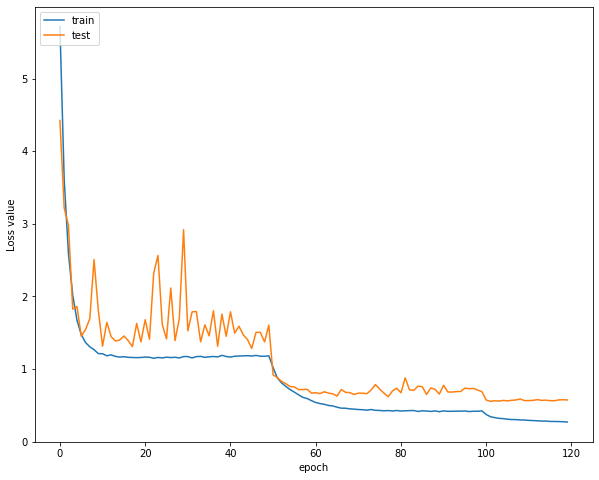

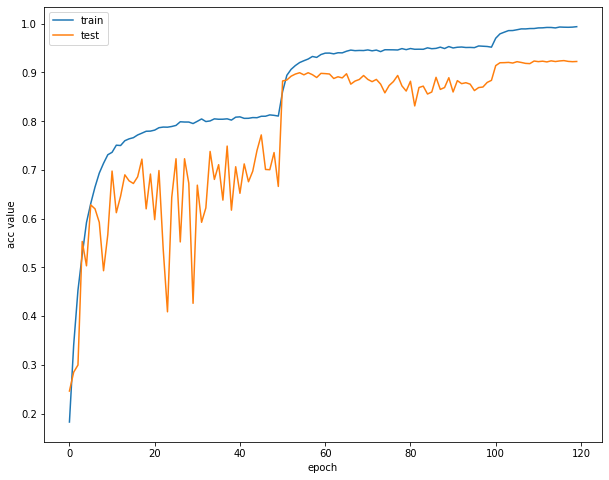

[5.714137448120117, 3.6094125106811523, 2.584108722305298, 2.019290448188782, 1.6725329074859618, 1.474821504020691, 1.3666028959274292, 1.3076902797698975, 1.2669700830459594, 1.2140575241088867, 1.2117137493133545, 1.1835592149734497, 1.1965026321411132, 1.1759650897979737, 1.165302202987671, 1.171465906906128, 1.1628065277099608, 1.1598102504730226, 1.1581995727539063, 1.1602666891098024, 1.1658569158554077, 1.1633384605407715, 1.1487250453948974, 1.1604931783676147, 1.1546875860214234, 1.164065945625305, 1.1589666446685791, 1.1627815511703492, 1.1537820171356201, 1.172609734725952, 1.1732639226913453, 1.154189721107483, 1.1722182741165161, 1.1754852624893188, 1.1623511280059815, 1.1698678350448608, 1.1739366111755372, 1.1676512075424195, 1.189796103477478, 1.1738783096313476, 1.165343977355957, 1.1776876865386963, 1.1803775667190552, 1.182777318763733, 1.184877151298523, 1.1803283981323243, 1.1887782091140746, 1.1777559364318848, 1.176845041847229, 1.1829409425735473, 1.02284799976

In [20]:
# plot loss and acc 
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('Loss value')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epoch')
plt.ylabel('acc value')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
print(history.history['loss'])
print(history.history['val_loss'])
print(history.history['accuracy'])
print(history.history['val_accuracy'])

In [18]:
vgg.save('/cnew/res.h5')